This practical notebook will take you through preparing and simulating the small protein villin (~35 amino acids) with Openmm. We will learn how to handle PDB file inputs, the use cases of different integrators, and some simple analysis.

Openmm, like most MD software, requires at least a system topology. The topology is how we define the molecules in our system and is built from lists of atoms for each unique individual molecule. In the case of proteins we typically follow the standard set by the RSCB PDB and represent proteins as molecular chains, contiguous peptide polymers of covalently bonded atoms. A single protein in the PDB can contain multiple chains and we must define these explicitly in our system topology. Luckily this is a well established approach with PDB files being a universal format for protein structures that all MD software will have some programmatic way of parsing and interpreting into their own internal representations of topologies.

Before we can proceed with simulating villin we must first retrieve a PDB file for it. This can be done through downloading from the RSCB PDB website or programmatically with python which we will do below.

In [2]:
import requests # requests is a library for programmatically quering the internet through http requests
import os # os is python's local file 

# the RSCB has a dedicate file transfer host that we can query for any given pdb id to retrieve the respective pdb file
RCSB_DOWNLOAD_URL = "https://files.rcsb.org/download/{pdb_id}.cif" # in reality we are actually downloading the more modern mmcif file format as opposed to the legacy .pdb format.

# this function is a simple utility for calling requests to download the specified pdb id and handle any errors
def download_mmcif(pdb_id, out_dir=".", overwrite=False):
    """
    Downloads mmCIF from RCSB to out_dir and returns the saved filepath.
    pdb_id: 4 letter pdb code e.g. "1TUP" or "1tup" (case-insensitive)
    """
    pdb_id = pdb_id.strip().lower()
    fname = f"{pdb_id}.cif"
    out_path = os.path.join(out_dir, fname)
    if os.path.exists(out_path) and not overwrite:
        return out_path

    url = RCSB_DOWNLOAD_URL.format(pdb_id=pdb_id)
    r = requests.get(url, timeout=20)
    if r.status_code == 200 and r.content:
        with open(out_path, "wb") as fh:
            fh.write(r.content)
        return out_path
    else:
        raise RuntimeError(f"Failed to download {pdb_id} from {url} (status={r.status_code})")

cif_file = download_mmcif("1YRF")
print(cif_file)

./1yrf.cif


We have downloaded the mmcif file for the chicken villin subdomain HP-35 pdb 1YRF which is a 35 amino acid X-ray resolved crystal structure. Villin is one of the smallest proteins available on the PDB and is an "ultra-fast" folder making it useful for MD practicals with little compute power and time. In the above code we note how we've downloaded an mmcif (or .cif) file rather than a .pdb file. Mmcif files were introduced to store my complete information in a more programmatically accessible and efficient file format than the more human readable pdb. For the purposes of this tutorial we also provide a .pdb file.

In [3]:
pdb_file = "1yrf_a_broken.pdb"

# now we can setup our system in openmm with our pdb file as a topology
# first lets import openmm
from openmm import *
from openmm.app import *

# openmm comes with a class to handle PDB files we can initiate with our input pdb file
pdb = PDBFile(pdb_file)

# We then use this as our topology for openmm's Modeller class which produces its internal topology representation
modeller = Modeller(pdb.topology, pdb.positions) # note how this returns a class instance which we want to store as a variable for later accession

We now have a system topology setup in openmm but this is useless without providing the system with a way to parameterise all the possible molecular/atomistic interactions in the system. Solutions to this are known as forcefields and are the core engine of MD simulations. Forcefields are energy based physics functions that aim to approximate atomistic interactions in the real world as closely as possible through classical mechanics. There are numerous variations of forcefields and their accuracy and generalisation to different systems as increased over the years including development of more specific fields for different biological models such as membrane proteins (more on that later).

For this practical we will use the Amber 14 force field which was developed for use with the Amber MD package.

In [4]:
from openmm.unit import nanometer # openmm provides a number of unit objects that allow us to specify what units we are using for any appropriate case.
# The syntax for applying a unit to a number in openmm is to use the * operator between the number and unit (also use division with / to specify per unit)

# Just like with the Modeller class openmm provides a ForceField class which is instanciated with a filepath to the file that specifies our force field.
# In this case openmm comes pre-bundled with amber14-all so we can just specify the filename without an absoloute path. 
# However this approach allows us to provide any plausible force field file if desired.
forcefield = ForceField("amber14-all.xml", "amber14/tip3pfb.xml") # notice how we also provide a second file which is the tip3pfb water model for amber14. If you're interested you can look into the tip3p water model.

# With out topology and force field established we can proceed to the next step which is the generation of a solvent to bath the molecule in:
modeller.addSolvent(forcefield, model="tip3p", padding=1 * nanometer) # we use the tip3p water model for our solvent meaning our villin is going to be surrounded by water
# did this error? if so why, can you interpret the error message to guess at what might have happened?

ValueError: No template found for residue 0 (LEU).  The atoms and bonds in the residue match LEU, but the set of externally bonded atoms is missing 1 N atom.  Is the chain missing a terminal capping group?  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#template

The reason this error'd is because the pdb file we've provided is "broken". Specifically it is missing two hydrogen atoms from the first Leucine in the sequence. If you look into the pdb file itself you will see that the Leucine is missing two hydrogens where atoms 9 and 10 should have been. In a typical MD (or any structural biology) workflow it is standard to use packages like PDBfixer to automatically detect and correct such issues. With openmm this can be easily achieved using the addHydrogens() method with our modeller instance as long as we provide a forcefield.

In [5]:
modeller.addHydrogens(forcefield, pH=7.0) # notice how we specify pH. This is 7.0 as default anyway so it was unnecessary but important to note as specifying higher or lower pHs can dictate the protonation state of residues such as histidine

# let's try adding our solvent again
modeller.addSolvent(forcefield, model="tip3p", padding=1 * nanometer)

Now we have everything we need for a complete MD system to run simulations from.

In [7]:
# initialise the full system
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, constraints=HBonds)
# here the nonbondedMethod argument is passed PME which is a class imported from openmm.apps to provide access to the Particle Mesh Ewald algorithm for parameterising long range electrostatic interactions efficiently.
# the constraints argument is similarly passed the HBonds object which tells openmm.apps our system will employ fixed hydrogen bond lengths throughout the simulations

The reason we specify fixed hydrogen bond constraints is that any atom-hydrogen bond vibrates at extremely high frequencies which require small time steps (<1fs) to safely and accurately integrate over. This constraint therefore allows larger time steps of > 2fs which significantly increases simulation speed with little accuracy loss and the variations in these bonds are largely negligible on the larger system. Similarly specifying PME means we use fast Fourier Transforms to compute long range Coloumb interactions which drastically improves performance particularly for larger systems.

Before running any simulations the standard protocol in MD is to run a brief relaxation step where we minimise the potential energy of the system. Although we have a "fixed" villin topology there are often still slight atomic overlaps or steric clashes from the crystal structure that will trigger high potential energies and numerical instabilities due to the nature of their geometry and our force field. Thus, a brief energy minimisation allows the system to "relax" into a local minimum energy conformation that maximises starting stability. This avoids starting simulation with extreme velocities leading to system explosion. Let's perform a brief energy minimisation using the standard Langevin integrator (more on that later) and a constant pressure and temperature.

In [8]:
# first we set a temperature and pressure to keep constant
from openmm.unit import kelvin, bar, picosecond, femtoseconds

temperature = 300 * kelvin
pressure = 1 * bar

# now initialise the Langevin integrator 
integrator = LangevinIntegrator(temperature, 1 / picosecond, 2 * femtoseconds) 
# the second argument specifies the friction coefficient which controls how strongly we couple the thermostat to the system
# the final argument specifies the integration timestep which is 2fs

# we add a barostat to enforce consistent temperature and pressue
# the barostat works by occasionally rescaling the size of the simulation box to maintain the specified temperature
# constant temperature is achieved through using the Langevin integrator (even though we supply the temperature to the barostat below)
# we supply the temperature below because the barostat must work in tandem with the integrator to maintain constant temperature when trying to maintain pressure.
system.addForce(MonteCarloBarostat(pressure, temperature)) # the MonteCarloBarostat uses Metropolis Monte Carlo sampling of the NPT ensemble

5

In [9]:
# perform the energy minimisation
simulation = Simulation(modeller.topology, system, integrator) # create a Simulation class instance with our topology, system and integrator
simulation.context.setPositions(modeller.positions) # set the initial atomic positions using those from our topology
simulation.minimizeEnergy(maxIterations=100) # start the energy minimisation and run for a maximum of 100 iterations or until minimised

# after the energy minimisation we can collect our atomic positions to update our initial pdb with its newly relaxed conformation
positions = simulation.context.getState(getPositions=True).getPositions()

# finally write the update pdb to file for later use
with open("init.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

We're now ready to run our first simulation. Typically in an MD workflow one would run a series of equilibration steps which are short simulations in NVT or NPT canonical ensembles that help the system find more global energy minima where the solvent is more organised and we have reached the average kinetic energy (temperature) specified by our thmoerstat and pressure specified by our barostat. Letting the solvent relax around our villin protein in a brief equilibration will lead to more stable production later. Let's perform a short equilibration for 10 ps. Usually this will be done with some form of position restraints which can be gradually relaxed but in our case villin is small enough that we can run it without.

In [10]:
save_iterations = 10
steps = 5000

simulation.reporters = []
simulation.reporters.append(DCDReporter("equilibration.dcd", save_iterations))
simulation.reporters.append(
    StateDataReporter(
        "equilibration_scalars.csv", 
        10, 
        step=True, 
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True
    )
)
simulation.step(steps)

<Axes: xlabel='Time (ps)'>

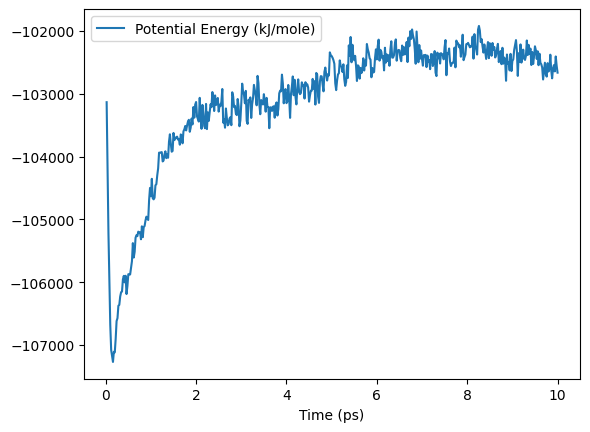

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# we'll use pandas to read the output reports csv file
df = pd.read_csv("equilibration_scalars.csv")

# then plot with matplotlib
plt.close("ener")
fig, ax = plt.subplots(num="ener")
df.plot(kind="line", x="Time (ps)", y="Potential Energy (kJ/mole)", ax=ax)

Great, we can clearly see that our potential energy is converging suggesting equilibration. Gauging when a system is equilibrated or how much further equilibration would impact the system and later production is very much subjective but can largely be ascertained from energy metrics. Next let's use this equilibrated system to initiate a short production at a high temperature.

In [ ]:
# in openmm we can continue our simulation from the same simulation object
# however if we did want to save a checkpoint for continuation in another session that's easy too
simulation.reporters = [] # reset our reporters

# let's change our temperature to something really high
new_temp = 450 * unit.kelvin
simulation.integrator.setTemperature(new_temp)

production_steps = 50000
save_iterations = 100

# prepare reporters as before
simulation.reporters.append(DCDReporter("production.dcd", save_iterations))
simulation.reporters.append(StateDataReporter("prod_scalars.csv", save_iterations,
                                              step=True, time=True,
                                              potentialEnergy=True, totalEnergy=True,
                                              temperature=True))
# run production
simulation.step(production_steps)

In [14]:
# we can use nglview to view our output trajectory as a widget within this notebook
import nglview
import mdtraj

# use mdtraj to load our output trajectory file 
traj = mdtraj.load("production.dcd", top="init.pdb") # mdtraj requires from the .dcd trajectory file and .pdb topology
view = nglview.show_mdtraj(traj, max_frame=500)

view

NGLWidget(max_frame=499)

In [15]:
# sometimes we might have to call view in a second cell to get the loaded trajectory we can actually play
view

NGLWidget(max_frame=499, n_components=1)

<Axes: xlabel='Time (ps)'>

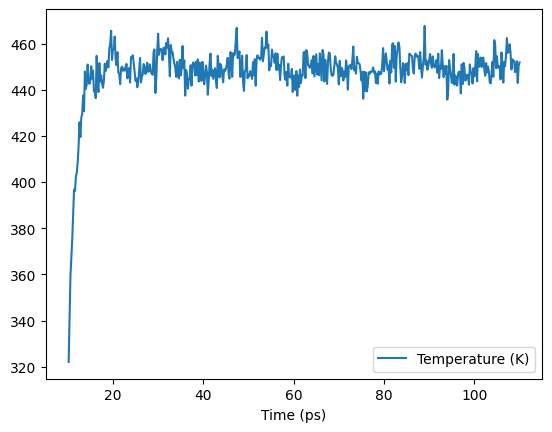

In [18]:
# let's also plot the temperature of the system to confirm the Langevin integrator's thermostat has done its job
df = pd.read_csv("prod_scalars.csv")
plt.close("ener")
fig, ax = plt.subplots(num="ener")
df.plot(kind="line", x="Time (ps)", y="Temperature (K)", ax=ax)

The thermostat clearly works but there is still a significant degree of oscillation in temperature around 450k. The reason for this is that the Langevin integrator is a stochastic solver that introduces inherent randomness. Why might this be a desired trait in MD simulations?

So we've now seen how to actually simulate villin and change the temperature, as well as view the resultant trajector. This particular production simulation only ran for 100ps which is far too short a time frame to see anything interesting. Even cooking the protein at the extremely high temperature of 450k would still take at least few nanoseconds to observe any larger unfolding-like conformational changes. If you're interested you could repet the above production but multiple the production steps by up to 100x and see how that effects the protein structure. If doing so you should consider how often we save trajectory snapshots to file. Above we use a save iterations value of 100 so for a 50,000 step production that's 500 snapshots which is essentially a more compressed pdb + configuration of the solvent including velocities and positions which can be heavy on memory space. If increasing the number of steps consider adjusting the save iterations proportionally so file sizes to not explode.

Finally, to illustrate the different integrators available let's compare the Langevin integrator we used earlier to the Verlet integrator. The Verlet integrator is NVE canonical meaning it is not a thermostat like the Langevin integrator and thus cannot constrain the system to a specified temperature. Run the cell below and note how in the output plots the Verlet integrator trajectory does not converge to our specified temperature.

In [ ]:
# unlike when we changed temperature, in order to alter our integrator we cannot continue with the same simulation object
# we must initialise a new simulation with the Verlet integrator 
# to do so we can store the state (positions and velocities) of our simulation to variables and use these to initiate a new simulation (or load from a checkpoint file)

# get positions + velocities from equilibrated sim
state = simulation.context.getState(getPositions=True, getVelocities=True, enforcePeriodicBox=True)
positions = state.getPositions()
velocities = state.getVelocities()

# let's define a function to handle running our production for any given integrator, positions and velocity
def run_simulation(integrator, label, positions, velocities=None, nsteps=50000, save_iterations=100):
    
    # initialise the simulations
    sim = Simulation(modeller.topology, system, integrator)
    sim.context.setPositions(positions) # use our previous positions
    if velocities:
        sim.context.setVelocities(velocities) # use our previous velocities
    else: # if velocities not provided we randomly sample velocities from the Boltzmann distribution
        # in this case we sample at 300K for the next part of the practical so this can be ignored here
        simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
        

    # setup reporters
    sim.reporters = []
    sim.reporters.append(DCDReporter(f"{label}_production.dcd", save_iterations))
    sim.reporters.append(
        StateDataReporter(f"scalars_{label}.csv", save_iterations,
                            step=True, temperature=True, elapsedTime=True,
                            potentialEnergy=True, totalEnergy=True)
    )

    sim.step(nsteps)

verlet = VerletIntegrator(2.0 * femtoseconds) # note how the VerletIntegrator does not take a temperature argument
langevin = LangevinIntegrator(new_temp, 1 / picosecond, 2 * femtoseconds) 

run_simulation(verlet, "Verlet_NVE", positions, velocities)
run_simulation(langevin, "Langevin_NVT", positions, velocities)


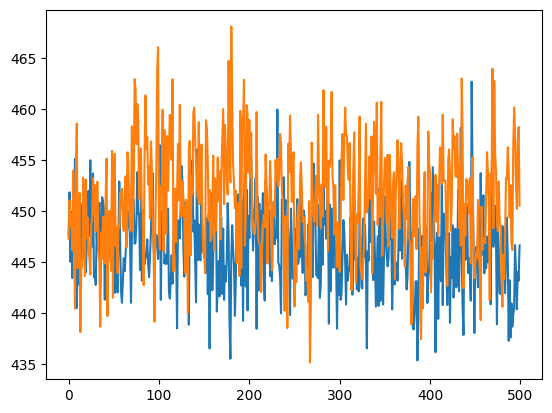

In [25]:
for x in ["scalars_Verlet_NVE.csv", "scalars_Langevin_NVT.csv"]:
    reporters = pd.read_csv(x)
    plt.plot(reporters["Temperature (K)"])

But wait a minute. Both simulations sit comfortably around 450K despite us stating the the Verlet integrator has no thermostat. This is because, although it has no direct temperature control the Verlet integrator is in the NVE canonical ensemble meaning it conserves energy. As we initiated both simulations with our previous langevin 450K simulation's velocities the energy has been conserved by the Verlet integrator (meaning the kinetic energy and therefore velocities are conserved) so the temperature stays around what we initialised it from. However, the verlet integrator will over time demonstrate temperature drift if there was any predisposition in a given direction in the velocities we started with. Just to illustrate what it would be like to start from no given velocities let's try one final simulation with Verlet but newly generated velocities.

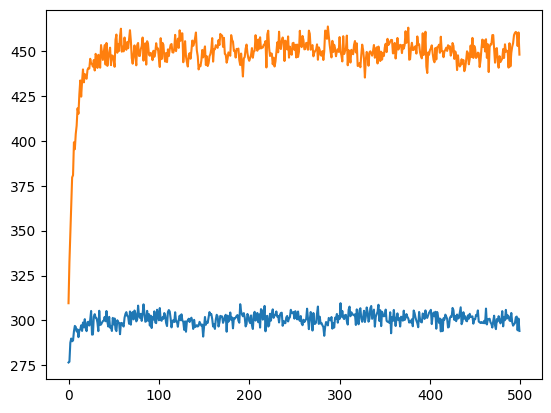

In [29]:
# first we must obtain new integrator instances as openmm ties our old integrators to their respective simulation objects
verlet2= VerletIntegrator(2.0 * femtoseconds)
langevin2 = LangevinIntegrator(new_temp, 1 / picosecond, 2 * femtoseconds) 

run_simulation(verlet2, "Verlet_NVE_no_vel", positions)
run_simulation(langevin2, "Langevin_NVT_no_vel", positions)

for x in ["scalars_Verlet_NVE_no_vel.csv", "scalars_Langevin_NVT_no_vel.csv"]:
    reporters = pd.read_csv(x)
    plt.plot(reporters["Temperature (K)"])

So now starting with the same positions as before but genrating new velocities at 300K we see how the Langevin integrator enforces a temeprature of 450k whilst Verlet does not.